In [ ]:
# pip install pubchempy

In [3]:
#conda install seaborn

Solving environment: \ 
  - https://repo.continuum.io/pkgs/main/noarch/noarch::defusedxml-0.6.0-py_0, https://repo.continuum.io/pkgs/main/osx-64/osx-64::bzip2-1.0.8-h1de35cc_0, https://repo.continuum.io/pkgs/main/osx-64/osx-64::intel-openmp-2019.4-233, https://repo.continuum.io/pkgs/main/osx-64/osx-64::pandoc-2.10.1-0
  - defaults/osx-64::bzip2-1.0.8-h1de35cc_0, https://repo.continuum.io/pkgs/main/noarch/noarch::defusedxml-0.6.0-py_0, https://repo.continuum.io/pkgs/main/osx-64/osx-64::intel-openmp-2019.4-233, https://repo.continuum.io/pkgs/main/osx-64/osx-64::pandoc-2.10.1-0
  - defaults/osx-64::intel-openmp-2019.4-233, https://repo.continuum.io/pkgs/main/noarch/noarch::defusedxml-0.6.0-py_0, https://repo.continuum.io/pkgs/main/osx-64/osx-64::bzip2-1.0.8-h1de35cc_0, https://repo.continuum.io/pkgs/main/osx-64/osx-64::pandoc-2.10.1-0
  - defaults/osx-64::bzip2-1.0.8-h1de35cc_0, defaults/osx-64::intel-openmp-2019.4-233, https://repo.continuum.io/pkgs/main/noarch/noarch::defusedxml-0.6.0-p

# ライブラリのインポート

In [1]:
import pubchempy as pcp
import pandas as pd
import numpy as np
import seaborn as sns

from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

from mordred import Calculator, descriptors
from mordred import  ABCIndex

import matplotlib.pyplot as plt
from statistics import mean
from math import sqrt
from rdkit import Chem
from sklearn import metrics
from sklearn import model_selection
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# PubChemからDBの取得

In [3]:
target_Compounds_Number = 10000

In [4]:
divList = []
resList = []
divNumber = 10000
j = 0
cid_list = np.arange(1,target_Compounds_Number+1).tolist()
tem_list = cid_list
properties = ['IUPACName','CanonicalSMILES','MolecularFormula']

while len(tem_list) >= divNumber:
    divList.append(tem_list[:divNumber])
    tem_list = tem_list[divNumber:]
    
if len(tem_list) > 0:
    divList.append(tem_list)
    
for i in divList:
    j = j + 1
    print(j)
    div_df = pd.DataFrame(pcp.get_properties(properties, i, 'cid'))
    resList.append(div_df)
    
smiles_df = pd.concat(resList, axis=0,ignore_index=True)
error_df1 = smiles_df[smiles_df['CanonicalSMILES'].isnull()]
smiles_df = smiles_df.dropna(subset=['CanonicalSMILES'])

1


In [5]:
smiles_df.to_csv("smiles.csv",header=False,index=False, columns=['CanonicalSMILES'])

In [6]:
divisionList = []
resultList = []
divisionNumber = 10000
tem_df = smiles_df
j = 0
while len(tem_df) >= divisionNumber:
    divisionList.append(tem_df.iloc[:divisionNumber])
    tem_df = tem_df.iloc[divisionNumber:]
    
if len(tem_df) > 0:
    divisionList.append(tem_df)
    
for i in divisionList:
    div_df = i
    j = j + 1
    print(j)
    PandasTools.AddMoleculeColumnToFrame(div_df, smilesCol='CanonicalSMILES', includeFingerprints=False)
    resultList.append(div_df)
    
smiles_df = pd.concat(resultList, axis=0)
error_df2 = smiles_df[smiles_df['ROMol'].isnull()]
smiles_df = smiles_df.dropna(subset=['ROMol'])

1


RDKit WARNING: [14:21:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:21:15] WARNING: not removing hydrogen atom without neighbors
/Users/raysmith/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/rdkit/Chem/PandasTools.py:416: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


In [7]:
mol_list = smiles_df['ROMol']

In [6]:
features_list_TCAA_rf = ["SsOH",
                         "C2SP2",
                        "SlogP_VSA11",
                        "SMR_VSA7",
                        "PEOE_VSA1",
                        "EState_VSA7",
                        "ATSC5are",
                        "nBondsKD",
                        "ATS1i",
                        "nBondsM"]

features_list_DCAA_rf = ["AATSC0are",
                         "ATSC3dv",
                         "SlogP_VSA11",
                         "ATS4m",
                         "ATS4Z",
                         "Xch-7d",
                         "PEOE_VSA1",
                         "SaasC",
                         "piPC4",
                         "VSA_EState9"]
features_list_TCAA_DCAA_rf = ["SsOH",
                         "C2SP2",
                        "SlogP_VSA11",
                        "SMR_VSA7",
                        "PEOE_VSA1",
                        "EState_VSA7",
                        "ATSC5are",
                        "nBondsKD",
                        "ATS1i",
                        "nBondsM"
                        "AATSC0are",
                        "ATSC3dv",
                        "ATS4m",
                        "ATS4Z",
                        "Xch-7d",
                        "SaasC",
                        "piPC4",
                        "VSA_EState9" ] 

calc_dummy = Calculator(descriptors, ignore_3D=False)
my_desc_names_TCAA = features_list_TCAA_rf
my_desc_names_DCAA = features_list_DCAA_rf
my_desc_names_TCAA_DCAA = features_list_TCAA_DCAA_rf                        
my_descs = []
for i, desc in enumerate(calc_dummy.descriptors):
    if desc.__str__()  in my_desc_names_TCAA:
       my_descs.append(desc)

calc_TCAA = Calculator(my_descs, ignore_3D=False)
my_descs = []
for i, desc in enumerate(calc_dummy.descriptors):
    if desc.__str__()  in my_desc_names_DCAA:
       my_descs.append(desc)

calc_DCAA = Calculator(my_descs, ignore_3D=False)
my_descs = []
for i, desc in enumerate(calc_dummy.descriptors):
    if desc.__str__()  in my_desc_names_TCAA_DCAA:
       my_descs.append(desc)

calc_TCAA_DCAA = Calculator(my_descs, ignore_3D=False)

In [7]:
calc = calc_TCAA_DCAA

In [10]:
divisionList2 = []
resultList2 = []
divisionNumber2 = 10000
tem_df = smiles_df
j = 0
while len(tem_df) >= divisionNumber:
    divisionList2.append(tem_df.iloc[:divisionNumber])
    tem_df = tem_df.iloc[divisionNumber:]
    
if len(tem_df) > 0:
    divisionList2.append(tem_df)
    
for i in divisionList2:
    div_df = i
    div_mol_list = div_df['ROMol']
    j = j + 1
    print(j)
    tem_qsar_preview = pd.DataFrame(calc.pandas(div_mol_list, nproc=4).fill_missing())
    div_df = pd.concat([div_df, tem_qsar_preview], axis=1)
    resultList2.append(div_df)
qsar_df = pd.concat(resultList2, axis=0)

1


  8%|▊         | 758/10000 [00:01<00:17, 516.47it/s]RDKit WARNING: [14:21:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:21:18] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:21:18] WARNING: not removing hydrogen atom without neighbors
 10%|▉         | 987/10000 [00:02<00:21, 428.07it/s]RDKit WARNING: [14:21:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:21:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:21:19] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 10000/10000 [00:19<00:00, 506.08it/s]


In [11]:
# qsar_preview = pd.DataFrame(calc.pandas(mol_list, nproc=4).fill_missing())
# qsar_df = pd.concat([smiles_df, qsar_preview], axis=1)

In [12]:
error_df3 = qsar_df[qsar_df.isnull().any(axis=1)]
qsar_df = pd.DataFrame(qsar_df, index = qsar_df.index).dropna(axis=0)

In [13]:
qsar_1000000_df = qsar_df
%store qsar_1000000_df

Stored 'qsar_1000000_df' (DataFrame)


In [14]:
%store qsar_df

Stored 'qsar_df' (DataFrame)


In [15]:
%store -r qsar_1000000_df
# qsar_df = qsar_1000000_df

In [16]:
ext_df = qsar_df.iloc[:, 5:]
X_ext_TCAA = ext_df
X_ext_DCAA = ext_df
ext_df.shape

(9988, 10)

In [8]:
mols = pd.read_excel("excel_py/training_data.xlsx", header=0)
df_result = mols[['DCAA (umol/mmol)', 'TCAA (umol/mmol)', 'HAAFP (umol/mmol)']]
Y = df_result.values
df_result = mols[['SMILES','DCAA (umol/mmol)', 'TCAA (umol/mmol)', 'HAAFP (umol/mmol)']]
PandasTools.AddMoleculeColumnToFrame(df_result, smilesCol='SMILES', includeFingerprints=False)
log_Y = np.log1p(Y)

In [9]:
df_result.shape

(299, 5)

In [10]:
exp_descriptor_data = pd.DataFrame(calc.pandas(df_result['ROMol']))
X_Exp_TCAA = exp_descriptor_data
X_Exp_DCAA = exp_descriptor_data

100%|██████████| 299/299 [00:00<00:00, 625.87it/s]


In [11]:
pipe_DCAA_rf = Pipeline(
    [
        ('std_scaler', StandardScaler()),
        ("RF", RandomForestRegressor(random_state = 17,
                                    n_estimators = 300,
                                    max_features = "auto",
                                    min_samples_split = 0.03,
                                    min_samples_leaf = 0.01,
                                    max_depth = 30,
                                    max_leaf_nodes = None,
                                    n_jobs = 1))
    ]
)

pipe_TCAA_rf = Pipeline(
    [
        ('std_scaler', StandardScaler()),
        ("RF", RandomForestRegressor(random_state = 17,
                                    n_estimators = 100,
                                    max_features = "auto",
                                     min_samples_split = 2,
                                     min_samples_leaf = 1,
                                     max_depth = None,
                                     max_leaf_nodes = None,
                                    n_jobs = 1))
    ]
)

In [12]:
pipe_TCAA_rf.fit(X_Exp_TCAA, log_Y[:,1])
Y_predicted_TCAA_rf = pipe_TCAA_rf.predict(X_ext_TCAA)

NameError: name 'X_ext_TCAA' is not defined

In [23]:
Y_predicted_TCAA_rf.shape

(9988,)

In [24]:
predicted_TCAA_df = pd.DataFrame(Y_predicted_TCAA_rf)
predicted_TCAA_df.columns = ["TCAA"]
predicted_TCAA_df.shape

(9988, 1)

In [25]:
qsar_df = qsar_df.reset_index(drop=True)

In [26]:
result_TCAA_df = pd.concat([predicted_TCAA_df, qsar_df], axis=1)
result_TCAA_df = result_TCAA_df.sort_values(by = ["TCAA"], ascending = False)

,TCAA,CID,CanonicalSMILES,IUPACName,MolecularFormula,ROMol,ATS1i,ATSC5are,nBondsM,nBondsKD,C2SP2,SsOH,PEOE_VSA1,SMR_VSA7,SlogP_VSA11,EState_VSA7
8643,6.006236,8655,COC1=CC(=CC(=C1O)OC)C=O,"4-hydroxy-3,5-dimethoxybenzaldehyde",C9H10O4,,3370.907669,-0.431607,7,4,5,9.442833,14.580253,17.696186,17.248535,0.0
8456,5.604557,8468,COC1=C(C=CC(=C1)C(=O)O)O,4-hydroxy-3-methoxybenzoic acid,C8H8O4,,2943.380974,0.8768,7,4,5,17.657289,14.949918,23.762553,11.499024,0.0
1177,5.520359,1183,COC1=C(C=CC(=C1)C=O)O,4-hydroxy-3-methoxybenzaldehyde,C8H8O3,,2757.975917,-0.173657,7,4,5,9.089546,9.843390,23.762553,11.499024,0.0
676,5.502430,681,C1=CC(=C(C=C1CCN)O)O,"4-(2-aminoethyl)benzene-1,2-diol",C8H11NO2,,3322.208480,-0.380037,6,3,5,17.966588,15.946722,23.762553,11.499024,0.0
134,5.442397,135,C1=CC(=CC=C1C(=O)O)O,4-hydroxybenzoic acid,C7H6O3,,2330.449222,-0.6675,7,4,5,17.139592,10.213055,29.828920,5.749512,0.0
6986,5.362905,6998,C1=CC=C(C(=C1)C=O)O,2-hydroxybenzaldehyde,C7H6O2,,2145.044165,-0.648178,7,4,5,8.879259,5.106527,29.828920,5.749512,0.0
704,5.313554,709,COC1=C(C=CC(=C1)C=CC(=O)O)O,3-(4-hydroxy-3-methoxyphenyl)prop-2-enoic acid,C10H10O4,,3503.214782,-0.472917,8,5,7,17.635393,14.949918,29.838573,11.499024,0.0
357,5.263347,359,C1=C(C=C(C=C1O)O)O,"benzene-1,3,5-triol",C6H6O3,,2235.716595,-3.0552,6,3,6,26.021667,15.319582,18.199101,17.248535,0.0
65,5.246903,66,C1=CC(=C(C=C1Cl)O)Cl,"2,5-dichlorophenol",C6H4Cl2O,,1850.700193,-0.0986953,6,3,6,8.883704,5.106527,28.244368,5.749512,0.0
8437,5.242975,8449,C1=CC(=C(C=C1Cl)Cl)O,"2,4-dichlorophenol",C6H4Cl2O,,1850.700193,0.534697,6,3,6,8.853117,5.106527,28.244368,5.749512,0.0

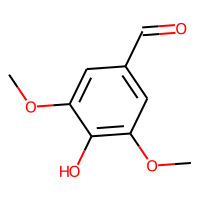
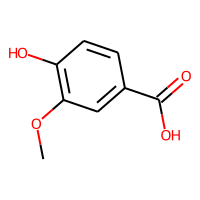
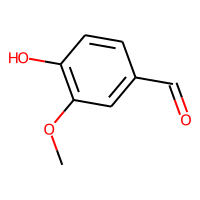
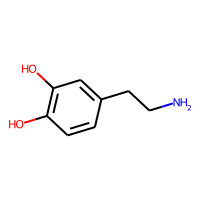
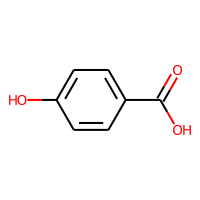
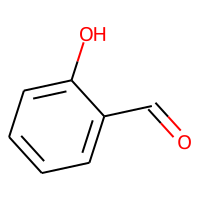
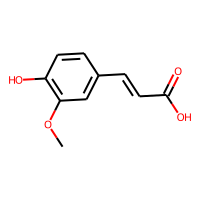
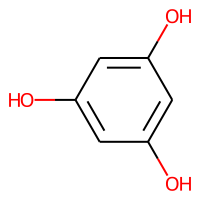
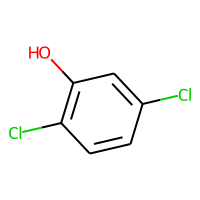
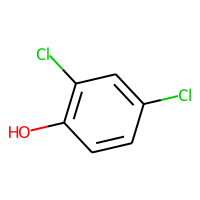

In [27]:
result_TCAA_df.head(10)

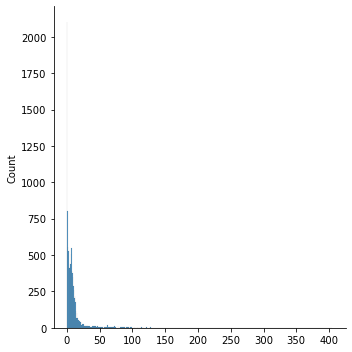

In [29]:
tcaa_distribution = result_TCAA_df["TCAA"].values
tcaa_distribution = np.exp(tcaa_distribution)-1
sns.displot(tcaa_distribution)

,10367,836263,42060,8642,889940,80350,70690,119043,437746,487962
CID,10383,840409,42240,8655,894092,80651,70966,119618,440729,491067
TCAA,5.99357,5.69189,5.67781,5.67047,5.62825,5.6243,5.61973,5.61586,5.60245,5.59213
IUPACName,"3,5-dimethoxyphenol","2,3-dibromo-4-(hydroxyiminomethyl)-6-methoxyphenol",(4-hydroxy-3-methoxyphenyl) acetate,"4-hydroxy-3,5-dimethoxybenzaldehyde",4-bromo-2-(hydroxymethyl)-6-methoxyphenol,methyl 2-hydroxy-3-methoxybenzoate,4-(aminomethyl)-2-methoxyphenol,"2-(1,3-benzodioxol-5-yl)-2-hydroxyacetic acid",2-hydroxy-2-(4-hydroxy-3-methoxyphenyl)acetaldehyde,"N'-(2,6-dihydroxyphenyl)carbamimidothioic acid"
ROMol,,,,,,,,,,

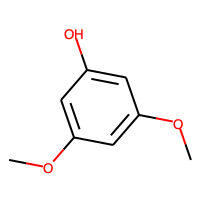
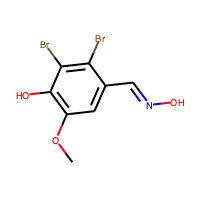
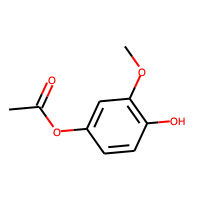
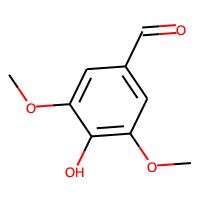
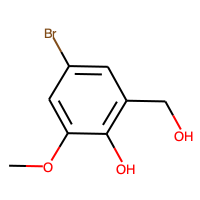
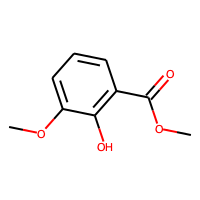
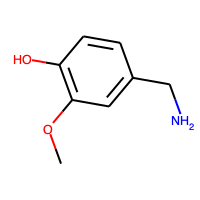
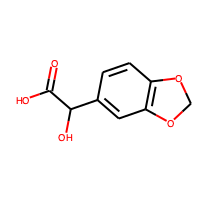
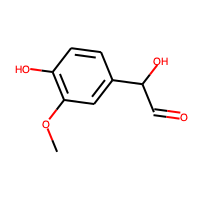
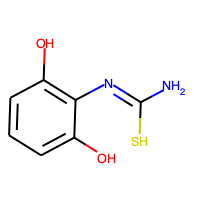

In [40]:
show_result_df = result_TCAA_df[["CID","TCAA","IUPACName","ROMol"]].iloc[0:10]
show_result_df = show_result_df.transpose()
show_result_df

# EAWAG-DDB

In [2]:
# intermediate_df = pd.read_excel("excel_py/prtr_results.xlsx", header=0)
intermediate_df = pd.read_excel("/Users/moriirei/Desktop/研究室/modeling of biodegradation/results1000.xlsx", header=0)
intermediate_df = intermediate_df.iloc[4:]
target_list = intermediate_df.iloc[0,1:]
target_list = target_list.rename("target")
intermediate_list = intermediate_df.iloc[1:,0]
intermediate_list = intermediate_list.rename("intermediate")
intermediate_df = intermediate_df.iloc[1:,1:]
intermediate_df.index = intermediate_list
intermediate_df.columns = target_list

In [3]:
intermediate_dic = {}
for target in target_list:
    tem_df = pd.DataFrame(intermediate_df[target].dropna())
    tem_df['target'] = tem_df.index
    tem_df.loc['target'] = target
    tem_df = tem_df.drop(target, axis=1)
    PandasTools.AddMoleculeColumnToFrame(tem_df, smilesCol='target', includeFingerprints=False)
    tem_df = tem_df.dropna(subset=['ROMol'])
    intermediate_dic[target] = tem_df

RDKit ERROR: [16:25:48] Can't kekulize mol.  Unkekulized atoms: 12 13 16 19
RDKit ERROR: 
RDKit ERROR: [16:25:48] non-ring atom 3 marked aromatic
RDKit ERROR: [16:25:48] non-ring atom 3 marked aromatic
RDKit ERROR: [16:25:48] Can't kekulize mol.  Unkekulized atoms: 20 21 24 27
RDKit ERROR: 
RDKit ERROR: [16:25:48] non-ring atom 11 marked aromatic
RDKit ERROR: [16:25:48] non-ring atom 11 marked aromatic
RDKit ERROR: [16:25:48] Can't kekulize mol.  Unkekulized atoms: 20 21 24 27
RDKit ERROR: 
RDKit ERROR: [16:25:48] non-ring atom 3 marked aromatic
RDKit ERROR: [16:25:49] non-ring atom 45 marked aromatic
RDKit ERROR: [16:25:49] Can't kekulize mol.  Unkekulized atoms: 44 45 48 51
RDKit ERROR: 
RDKit ERROR: [16:25:49] Can't kekulize mol.  Unkekulized atoms: 26 27 30 31 42
RDKit ERROR: 
RDKit ERROR: [16:25:49] non-ring atom 3 marked aromatic
RDKit ERROR: [16:25:49] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 17
RDKit ERROR: 
RDKit ERROR: [16:25:49] Can't kekulize mol.  Unkekulized

In [14]:
for target in target_list:
    tem_df = intermediate_dic[target]
    tem_mol_list = tem_df['ROMol']
    tem_qsar_preview = pd.DataFrame(calc.pandas(tem_mol_list, nproc=4).fill_missing())
    intermediate_dic[target] = pd.concat([tem_df, tem_qsar_preview], axis=1)

  0%|          | 0/1 [00:00<?, ?it/s]RDKit WARNING: [16:28:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:28:54] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:28:54] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 7/7 [00:00<00:00, 162.01it/s]


100%|██████████| 5/5 [00:00<00:00, 86.63it/s]


,TCAA,0,ROMol,ATS4Z,ATS4m,ATS1i,ATSC3dv,ATSC5are,nBondsKD,C2SP2,Xch-7d,SaasC,SsOH,PEOE_VSA1,SMR_VSA7,SlogP_VSA11,EState_VSA7,VSA_EState9,piPC4
0,1.824359,COC1=CC=CC=C1N,,344.0,1095.585041,2698.251214,-23.000000,-0.577122,3,6,0.142259,1.414352,0.000000,10.470530,24.265468,5.749512,18.199101,1.60287,3.929372
1,0.370208,CC1=CC=CC=C1[N+](=O)[O-],,494.0,1718.700772,2518.928854,-2.283737,-2.629649,4,5,0.131446,0.884259,0.000000,0.000000,39.943238,0.000000,0.000000,0.00000,4.141149
2,5.480672,C1=CC(=CC=C1C(=O)O)O,,388.0,1326.981154,2330.449222,-29.750000,-0.667500,4,5,0.131446,0.252593,17.139592,10.213055,29.828920,5.749512,0.000000,0.00000,4.066888
3,3.925950,C1=CC=C(C=C1)O,,112.0,315.263973,1864.906480,-14.840237,-0.040355,3,6,0.102062,0.321759,8.632222,5.106527,30.331835,5.749512,6.066367,0.00000,3.640870
4,3.051263,C1=CC=C(C=C1)N,,118.0,313.568493,2085.319462,-17.551020,0.046997,3,6,0.102062,0.821759,0.000000,5.733667,30.331835,0.000000,30.331835,0.00000,3.640870

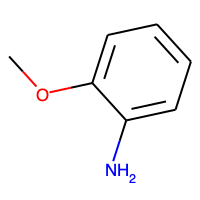
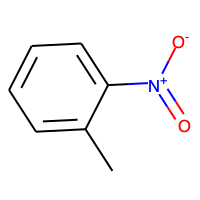
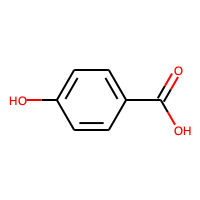
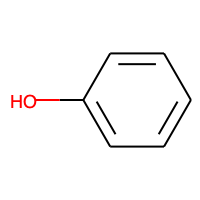
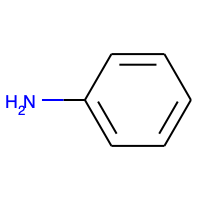

In [15]:
HQ_df = pd.DataFrame(['COC1=CC=CC=C1N',
'CC1=CC=CC=C1[N+](=O)[O-]',
'C1=CC(=CC=C1C(=O)O)O',
'C1=CC=C(C=C1)O',
'C1=CC=C(C=C1)N'])
PandasTools.AddMoleculeColumnToFrame(HQ_df, smilesCol=0, includeFingerprints=False)
HQ_mol_list = HQ_df['ROMol']
HQ_qsar_preview = pd.DataFrame(calc.pandas(HQ_mol_list, nproc=4).fill_missing())
HQ_df = pd.concat([HQ_df, HQ_qsar_preview], axis=1)
pipe_TCAA_rf.fit(X_Exp_TCAA, log_Y[:,1])
HQ_Y_predicted_TCAA_df = pd.DataFrame(pipe_TCAA_rf.predict(HQ_qsar_preview))
HQ_Y_predicted_TCAA_df.columns = ["TCAA"]
HQ_result_TCAA_df = pd.concat([HQ_Y_predicted_TCAA_df, HQ_df], axis=1)
HQ_result_TCAA_df

In [15]:
pipe_TCAA_rf.fit(X_Exp_TCAA, log_Y[:,1])
result_intermediate_dic = {}
for target in target_list:
    tem_df = intermediate_dic[target]
    tem_ext_df = tem_df.iloc[:, 2:]
    tem_Y_predicted_TCAA_rf = pipe_TCAA_rf.predict(tem_ext_df)
    tem_predicted_TCAA_df = pd.DataFrame(tem_Y_predicted_TCAA_rf)
    tem_predicted_TCAA_df.columns = ["TCAA"]
    tem_predicted_TCAA_df.index = tem_df.index
    tem_result_TCAA_df = pd.concat([tem_predicted_TCAA_df, tem_df], axis=1)
    tem_result_TCAA_df = tem_result_TCAA_df.sort_values(by = ["TCAA"], ascending = False)
    result_intermediate_dic[target] = tem_result_TCAA_df

In [16]:
higher_intermediate_list1 = [] #targetが1番でない
higher_intermediate_list2 = [] #targetより１０倍TCAAの大きい物質を持つ。3,6,18が面白い。６が特に印象的
higher_intermediate_list3 = [] #targetが最下位。理論上、必ず生成量が増える。
for target in target_list:
    tem_df = result_intermediate_dic[target]
    tem_df["TCAA"].loc["rate"] = result_intermediate_dic[target].iloc[0]["TCAA"]/result_intermediate_dic[target].loc["target"]["TCAA"]
    if tem_df.iloc[0]["target"] != target:
        higher_intermediate_list1.append(tem_df)
    if result_intermediate_dic[target].iloc[0]["TCAA"]/result_intermediate_dic[target].loc["target"]["TCAA"] >= 10:
        higher_intermediate_list2.append(tem_df)
    if tem_df.iloc[len(tem_df)-1]["target"] == target:
        higher_intermediate_list3.append(tem_df)

737 19 165


,TCAA,target,ROMol,ATS4Z,ATS4m,ATS1i,ATSC3dv,ATSC5are,nBondsKD,C2SP2,Xch-7d,SaasC,SsOH,PEOE_VSA1,SMR_VSA7,SlogP_VSA11,EState_VSA7,VSA_EState9,piPC4
intermediate,,,,,,,,,,,,,,,,,,,
N,0.722825,N,,0.0,0.000000,592.923391,0.000000,0.000000,0,0,0.0,0,0.000000,6.150546,0.0,0.0,0.0,0.0,0.0
CC(N)O,0.119744,CC(N)O,,11.0,11.176704,1636.752739,-22.214876,0.000000,0,0,0.0,0,7.833333,10.840195,0.0,0.0,0.0,0.0,0.0
OCC=O,0.048808,OCC=O,,9.0,17.143056,1078.032933,4.000000,0.000000,1,0,0.0,0,7.506944,9.901065,0.0,0.0,0.0,0.0,0.0
NCC=O,0.024098,NCC=O,,18.0,34.286112,1298.445915,0.370370,0.000000,1,0,0.0,0,0.000000,10.528205,0.0,0.0,0.0,0.0,0.0
target,0.005598,C(CO)N,,29.0,52.469424,1636.752739,3.694215,0.126825,0,0,0.0,0,7.750000,10.840195,0.0,0.0,0.0,0.0,0.0

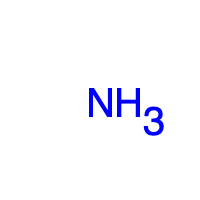
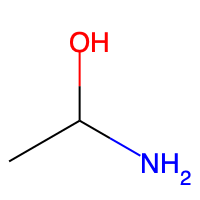
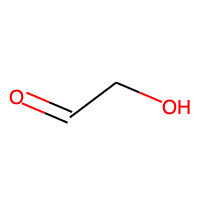
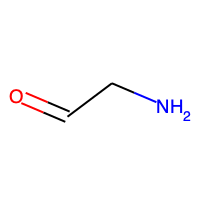
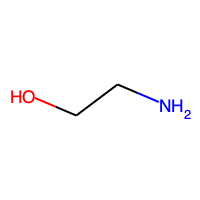

In [20]:
print(len(higher_intermediate_list1),
len(higher_intermediate_list2),
len(higher_intermediate_list3))
higher_intermediate_list2[18]

,TCAA,target,ROMol,ATS4Z,ATS4m,ATS1i,ATSC3dv,ATSC5are,nBondsKD,C2SP2,Xch-7d,SaasC,SsOH,PEOE_VSA1,SMR_VSA7,SlogP_VSA11,EState_VSA7,VSA_EState9,piPC4
intermediate,,,,,,,,,,,,,,,,,,,
Oc1ccc(C=O)cc1O,4.608971,Oc1ccc(C=O)cc1O,,397.0,1344.124210,2330.449222,-17.250000,0.632500,4,5,0.184195,-0.147685,17.595610,10.213055,23.762553,11.499024,0.000000,0.0,4.141149
Oc1cc(C=O)ccc1[N+]([O-])=O,3.304527,Oc1cc(C=O)ccc1[N+]([O-])=O,,703.0,2585.663200,2551.432144,-2.657439,-2.433752,5,5,0.155438,-0.691389,8.992315,5.106527,33.876871,5.749512,0.000000,0.0,4.392905
Nc1ccc(C=O)cc1,2.247521,Nc1ccc(C=O)cc1,,284.0,910.735840,2365.457147,-18.000000,0.046028,4,5,0.142259,1.337778,0.000000,5.733667,29.828920,0.000000,0.000000,0.0,3.986667
[O-]C(=O)c1ccc(cc1)[N+]([O-])=O,1.278395,[O-]C(=O)c1ccc(cc1)[N+]([O-])=O,,578.0,2081.742814,2366.247868,1.328125,-3.443863,5,5,0.096225,-0.207778,0.000000,9.901065,39.943238,0.000000,0.000000,0.0,4.274928
ONc1ccc(C=O)cc1,0.596090,ONc1ccc(C=O)cc1,,394.0,1325.285674,2550.926393,-11.577855,-0.448060,4,5,0.117851,1.170926,8.362860,0.000000,29.828920,0.000000,5.480097,0.0,4.066888
target,0.315628,C1=CC(=CC=C1C=O)[N+](=O)[O-],,480.0,1691.407156,2366.027087,-1.546875,-1.844863,5,5,0.107038,0.436296,0.000000,0.000000,39.943238,0.000000,0.000000,0.0,4.210274

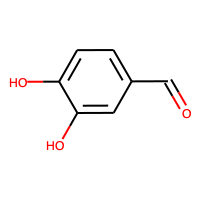
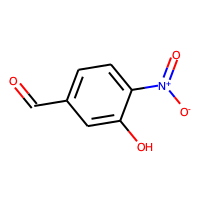
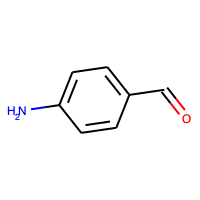
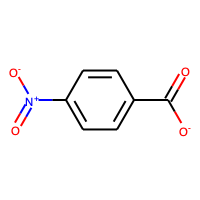
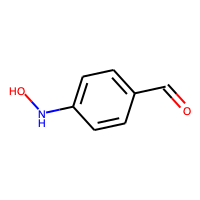
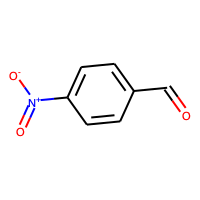

In [21]:
result_intermediate_dic["C1=CC(=CC=C1C=O)[N+](=O)[O-]"]


In [29]:
prtr_list2_3_target_smiles_df = []
prtr_list2_3_target_list = []
properties = ['IUPACName', 'MolecularFormula','CanonicalSMILES']
for i in higher_intermediate_list3:
    if i["TCAA"].loc["rate"] >= 10:
        tem_df = pd.DataFrame(pcp.get_properties(properties, i["target"].loc["target"],'smiles'))
        tem_df["rate"] = i["TCAA"].loc["rate"]
        tem_df["max_TCAA"] = i["TCAA"].iloc[0]
        prtr_list2_3_target_list.append(tem_df)
prtr_list2_3_target_df = pd.concat(prtr_list2_3_target_list, axis=0)
prtr_list2_3_target_df

    

,CID,MolecularFormula,CanonicalSMILES,IUPACName,rate,max_TCAA
0,887,CH4O,CO,methanol,25.724280,0.941418
0,118,C4H9NO,C(CC=O)CN,4-aminobutanal,27.152791,0.902139
0,401,C3H6N2O2,C1C(C(=O)NO1)N,"4-amino-1,2-oxazolidin-3-one",37.983014,0.902139
0,541,C7H5NO3,C1=CC(=CC=C1C=O)[N+](=O)[O-],4-nitrobenzaldehyde,14.090342,4.309666
0,750,C2H5NO2,C(C(=O)O)N,2-aminoacetic acid,69.629892,0.902139
0,428,C3H10N2,C(CN)CN,"propane-1,3-diamine",19.330000,0.902139
0,44,C3H2O5-2,C(C(=O)[O-])(C(=O)[O-])O,2-hydroxypropanedioate,16.567830,0.821228
0,700,C2H7NO,C(CO)N,2-aminoethanol,38.153803,0.902139


In [21]:
prtr_list2_3_target_df.to_csv("prtr_category2and3.csv",header=True,index=False)

In [34]:
higher_intermediate_list3[8]["target"].loc["target"]

'CC1=C(C(=CC=C1)C)O'

intermediate,Oc1ccc(C=O)cc1O,Oc1cc(C=O)ccc1[N+]([O-])=O,Nc1ccc(C=O)cc1,[O-]C(=O)c1ccc(cc1)[N+]([O-])=O,ONc1ccc(C=O)cc1,target
ROMol,,,,,,
raw_TCAA,99.3808,26.2357,8.46425,2.59087,0.815008,0.371121

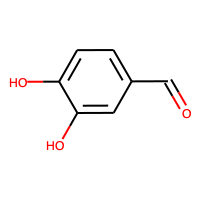
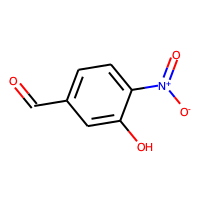
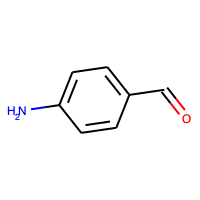
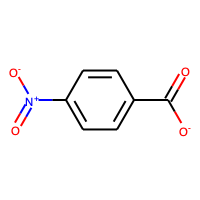
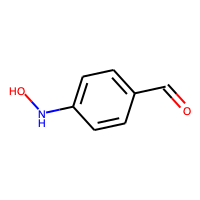
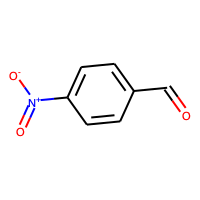

In [26]:
result_intermediate_dic["C1=CC(=CC=C1C=O)[N+](=O)[O-]"][["raw_TCAA"]] = np.exp(result_intermediate_dic["C1=CC(=CC=C1C=O)[N+](=O)[O-]"][["TCAA"]]) - 1
result_intermediate_dic["C1=CC(=CC=C1C=O)[N+](=O)[O-]"][["ROMol","raw_TCAA"]].transpose()


In [69]:
result_intermediate_dic["C=CC(=O)O"][["TCAA"]].transpose()

intermediate,OCCC([O-])=O,CCC([O-])=O,[O-]C(=O)C1CO1,target
TCAA,0.360605,0.046783,0.044677,0.010995


In [68]:
result_intermediate_dic["CC(=O)NC1=CC=C(C=C1)O"][["TCAA"]].transpose()

intermediate,CC(=O)Nc1ccc(O)c(O)c1,CC(=O)Nc1ccc(O)c(O)c1O,Oc1ccc(O)c(O)c1,target,Nc1ccc(O)cc1,CC(N)=O,CC([O-])=O
TCAA,5.554389,4.821625,4.461768,4.141139,3.246766,0.038455,0.031633


# PRTR制度物質の導入

In [4]:
PRTR_df = pd.read_excel("/Users/moriirei/Desktop/研究室/modeling of biodegradation/PRTR.xlsx", header=0)
PRTR_df = pd.DataFrame(PRTR_df)
PRTR_df = PRTR_df.iloc[11:,1:4]
PRTR_df.columns = ["No","CAS","Name"]
drop_PRTR_df = PRTR_df[PRTR_df["CAS"] == "-"]
PRTR_df = PRTR_df[PRTR_df["CAS"] != "-"]
PRTRs_df = PRTR_df[PRTR_df["CAS"].str.contains("\n")]
PRTR_df = PRTR_df[~PRTR_df["CAS"].str.contains("\n")]
for i in PRTRs_df.itertuples():
    print(i.No)
    tem_cas = i.CAS
    tem_list = tem_cas.splitlines()
    for j in tem_list:
        print([i.No,j,i.Name])
        PRTR_df = PRTR_df.append({"No":i.No,"CAS":j,"Name":i.Name},ignore_index=True)
        
PRTR_df = PRTR_df.sort_values('No')
PRTR_df

89
[89, '95-51-2', 'クロロアニリン']
[89, '106-47-8', 'クロロアニリン']
[89, '108-42-9', 'クロロアニリン']
108
[108, '7085-19-0', '（ＲＳ）－２－（４－クロロ－オルト－トリルオキシ）プロピオン酸']
[108, '93-65-2', '（ＲＳ）－２－（４－クロロ－オルト－トリルオキシ）プロピオン酸']
181
[181, '95-50-1', 'ジクロロベンゼン']
[181, '106-46-7', 'ジクロロベンゼン']
257
[257, '112-30-1', 'デシルアルコール']
[257, '25339-17-7', 'デシルアルコール']
299
[299, '95-53-4', 'トルイジン']
[299, '106-49-0', 'トルイジン']
348
[348, '95-54-5', 'フェニレンジアミン']
[348, '106-50-3', 'フェニレンジアミン']
[348, '108-45-2', 'フェニレンジアミン']


,No,CAS,Name
0,2,79-06-1,アクリルアミド
1,3,140-88-5,アクリル酸エチル
2,5,2439-35-2,アクリル酸２－（ジメチルアミノ）エチル
3,6,818-61-1,アクリル酸２－ヒドロキシエチル
4,7,141-32-2,アクリル酸ノルマル－ブチル
...,...,...,...
416,458,78-42-2,りん酸トリス（２－エチルヘキシル）
417,459,115-96-8,りん酸トリス（２－クロロエチル）
418,460,1330-78-5,りん酸トリトリル
419,461,115-86-6,りん酸トリフェニル


In [8]:
import requests
import json

api = "https://cactus.nci.nih.gov/chemical/structure/{CAS}/smiles"
url = api.format(CAS = "79-06-1")
r = requests.get(url)
prtr_smiles_list.append(r.text)
print(r.text)

SSLError: HTTPSConnectionPool(host='cactus.nci.nih.gov', port=443): Max retries exceeded with url: /chemical/structure/79-06-1/smiles (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)'),))

In [11]:
r = requests.get("https://cactus.nci.nih.gov/chemical/structure/79-06-1/smiles")

SSLError: HTTPSConnectionPool(host='cactus.nci.nih.gov', port=443): Max retries exceeded with url: /chemical/structure/79-06-1/smiles (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)'),))

In [14]:
# 存在する URL
get_url_info = requests.get('http://localhost:8080/python.org.html')
status_code = get_url_info.status_code
print(status_code) # => 200 



ConnectionError: HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /python.org.html (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x1a2bb42438>: Failed to establish a new connection: [Errno 61] Connection refused',))

In [7]:
    
prtr_smiles_list = []
for i in PRTR_df.itertuples():
    cas = i.CAS
    url = api.format(CAS = cas)
    r = requests.get(url)
    prtr_smiles_list.append(r.text)
    print(r.text)
prtr_smiles_df = pd.DataFrame(prtr_smiles_list)

SSLError: HTTPSConnectionPool(host='cactus.nci.nih.gov', port=443): Max retries exceeded with url: /chemical/structure/79-06-1/smiles (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)'),))

In [119]:
prtr_smiles_df.columns = ["CanonicalSMILES"]
prtr_smiles_df.to_csv("prtr_smiles.csv",header=False,index=False, columns=['CanonicalSMILES'])

In [182]:
prtr_df_list = []
properties = ['IUPACName', 'MolecularFormula','CanonicalSMILES']
# try:
#     prtr_df.append(pcp.get_properties(properties, prtr_smiles_list,'smiles'))
# except:
#         print('Error')
#prtr_smiles_df["CanonicalSMILES"]
prtr_df = []
for i in prtr_smiles_df.itertuples():
    print(i.CanonicalSMILES)
    try:
        prtr_df_list.append(pd.DataFrame(pcp.get_properties(properties, i.CanonicalSMILES,'smiles')))
    except:
        print('Error')
prtr_df = pd.concat(prtr_df_list, axis=0)
prtr_df

In [183]:
prtr_df.to_csv("prtr_smiles.csv",header=False,index=False, columns=['CanonicalSMILES'])

In [ ]:
#qsar_preview.head()
#qsar_preview.describe(include='all')
# qsar_features = []
# for mol in mol_list:
#     qsar_features.append(np.array(calc(mol).fill_missing()[:]))
    
# qsar_features = np.vstack(qsar_features)
# df_qsar = pd.DataFrame(qsar_features, columns = qsar_preview.columns).dropna(axis=1)
# df_qsar.describe(include='all')
# df_qsar2 = pd.DataFrame(calc.pandas(mol_list).fill_missing())
# df_qsar2 = pd.DataFrame(df_qsar2, columns = df_qsar2.columns).dropna(axis=1)
# df_qsar2.describe(include='all')
# df_qsar = df_qsar.loc[:, (df_qsar != 0).any(axis=0)]
# df_qsar.describe(include='all')
# features = list(df_qsar.columns.values)
# X_df = pd.DataFrame(X)
# X_df.head()
# X_df = X_df.rename(columns=dict(zip(X_df,features)))


# features_list_TCAA_rf = ["SsOH",
#                          "C2SP2",
#                         "SlogP_VSA11",
#                         "SMR_VSA7",
#                         "PEOE_VSA1",
#                         "EState_VSA7",
#                         "ATSC5are",
#                         "nBondsKD",
#                         "ATS1i",
#                         "nBondsM"]

# features_list_DCAA_rf = ["AATSC0are",
#                          "ATSC3dv",
#                          "SlogP_VSA11",
#                          "ATS4m",
#                          "ATS4Z",
#                          "Xch-7d",
#                          "PEOE_VSA1",
#                          "SaasC",
#                          "piPC4",
#                          "VSA_EState9"]
# X_ext_TCAA = X_df.filter(features_list_TCAA_rf, axis = 1)

AttributeError: 'list' object has no attribute 'head'

In [ ]:
for i in cate